##### Author: Pablo Iañez Picazo 
##### Biomedical Data Science lab, ISGlobal

In [1]:
# Load all the necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cluster import KMeans

import random
import umap

random.seed(22)
sns.set_style("ticks")

# Supress all warnings (bcoz they're quite annoying)
import warnings

warnings.filterwarnings("ignore")

import sys

sys.path.append("/home/pianez/phd/projects/hsc_nucleus/hsc_rhoa")
from methods import hsc_spatial_stats as hsc
from globals import batches_out, new_names

2025-06-28 20:54:31.817868: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-28 20:54:31.846391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-28 20:54:31.846415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-28 20:54:31.847209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-28 20:54:31.852480: I tensorflow/core/platform/cpu_feature_guar

In [2]:
sns.set(rc={"figure.figsize": (20, 16)})
sns.set_style("whitegrid")

In [3]:
# ------------------------ Set up some parameters --------------------------- #
# Image resolution after resizing, which is 5 micrometers per pixel
res = 0.1
# cluster forming threshold - threshold at which intensities above this value
# will be considered belonging to a DAPI-Intense Region (DIR)
# Intensities to 0.6 are the one in the quantile 0.80 in young, old and treated
cft = 0.6
norm = "z_score"
folder = "../data/preprocessed/"
conditions = [
    "young",
    "aged",
    "aged_treated_RhoAi",
    "myeloid_progenitors",
]

palette = {
    "Young": (0.00392, 0.45098, 0.69803),
    "Aged": (0.00784, 0.61960, 0.45098),
    "Aged + Ri": (0.8, 0.47058, 0.73725),
}

In [4]:
nuc_df = pd.read_csv(
    f"results/z_score_nuclei_3d_res{res}_cf{cft}_filt_df.csv", index_col=0
)
nuc_df = hsc.fix_labels(nuc_df)

In [5]:
MP_batches = [
    "20210120_PHF8-OldAB",
    "20210414_KDM4B",
    "20210429_H3K9me2-Cy3",
    "20211203_KDM3A",
    "20210421_PHF8-OldAB",
    "20210916_KDM3A_2",
    "20201109_KDM4B",
    "20210126_KDM4A_2",
    "20210831_H3K9me2",
    "20210122_PHF8-NewAB",
    "20210114_KDM4B",
    "20210430_PHF8-OldAB",
    "20210415_KDM4A",
    "20210126_KDM4A",
    "20210121_PHF8-NewAB",
    "20210505_H3K9me2",
    "20210112_H3K9me2",
    "20210916_KDM3A",
]

In [6]:
print(nuc_df.shape)
nuc_df = nuc_df[~nuc_df["im_batch"].isin(batches_out)]
print(nuc_df.shape)

(837, 92)
(780, 92)


In [7]:
features = [
    "volume",
    "width",
    "length",
    "height",
    "height deviation",
    "aspect ratio",
    "major axis length",
    "minor axis length",
    "min intensity",
    "max intensity",
    "solidity",
    "surface area",  # highly correlated with volume
    "sphericity",
    "invagination proportion",  # highly correlated with solidity
    "DIRs volume",
    "DIRs width",
    "DIRs length",
    "DIRs height",
    "intensity 0-0.5µm",
    "intensity 1-1.5µm",
    "intensity ratio",
    "DIRs aspect ratio",
    "DIRs surface area",
    "DIRs major axis length",
    "DIRs sphericity",
    "DIRs surface/volume",
    "DIRs mean intensity",
    "DIRs max intensity",
    "DIRs solidity",
    "DIRs centroid distance to border",  # highly correlated with DIRs_mean_distance2border
    "DIRs distance to border",
    "number of DIRs",
    "largest slide area",  # highly correlated with 2D_slide_volume
    "largest slide major axis length",
    "largest slide minor axis length",
    "largest slide perimeter",  # highly correlated with 2D_slide_area
    "largest slide roundness",  # highly correlated with 2D_slide_EOP
    "largest slide compactness",
    "largest slide EOP",
    "condition",
    "im_path",
    "im_batch",
    "im_nuc",
]

# Those features commented are the one filtered out during correlation analyses
sig_f_both = [
    "volume",
    "width",
    "length",
    "aspect ratio",
    "minor axis length",
    "min intensity",
    # "surface_area",
    "sphericity",
    "DIRs volume",
    "DIRs length",
    # "DIRs_height",
    "intensity 0-0.5µm",
    # "int_1.0-1.5",
    "intensity ratio",
    "DIRs major axis length",
    "DIRs mean intensity",
    # "DIRs_max_intensity",
    "DIRs sphericity",
    # "DIRs_surface/volume",
    "DIRs solidity",
    "number of DIRs",
    # "DIRs_centroid_distance2border",
    "DIRs distance to border",
    # "2D_slide_area",
    "largest slide major axis length",
    "largest slide minor axis length",
    # "2D_slide_perimeter",
    # "2D_slide_roundness",
    "largest slide EOP",
]

In [8]:
# nuc_df = nuc_df[nuc_df["condition"].isin(["Young", "Aged", "Aged + Ri", "MP"])]
subset_df = nuc_df[nuc_df["condition"].isin(["Young", "Aged", "Aged + Ri"])]
subset_df = subset_df.rename(columns=new_names)
subset_df = subset_df[features]
subset_df["DIRs distance to border"] = (
    subset_df["DIRs distance to border"] * res
)

In [9]:
subset_df.condition.value_counts()

condition
Young        177
Aged         164
Aged + Ri    144
Name: count, dtype: int64

In [10]:
corrmat = subset_df[sig_f_both].corr()
corrmat = corrmat.rename_axis(None).rename_axis(None, axis=1)
corrmat = corrmat.stack().reset_index()
corrmat.columns = ["var_1", "var_2", "correlation"]
corrmat = corrmat[corrmat["correlation"] != 1]
corrmat.sort_values(by="correlation", ascending=False).head(20)

var_1                            var_2  \
80                 minor axis length                           volume   
4                             volume                minor axis length   
190                intensity 0-0.5µm                  intensity ratio   
209                  intensity ratio                intensity 0-0.5µm   
151                      DIRs volume           DIRs major axis length   
227           DIRs major axis length                      DIRs volume   
360  largest slide minor axis length                           volume   
18                            volume  largest slide minor axis length   
364  largest slide minor axis length                minor axis length   
98                 minor axis length  largest slide minor axis length   
342  largest slide major axis length                           length   
57                            length  largest slide major axis length   
167                      DIRs length                      DIRs volume   
148                      DIRs volume                      DIRs length   
341  largest slide major axis length                            width   
37                             width  largest slide major axis length   
109                    min intensity                intensity 0-0.5µm   
185                intensity 0-0.5µm                    min intensity   
2                             volume                           length   
40                            length                           volume   

     correlation  
80      0.766306  
4       0.766306  
190     0.723796  
209     0.723796  
151     0.705157  
227     0.705157  
360     0.687662  
18      0.687662  
364     0.684031  
98      0.684031  
342     0.682625  
57      0.682625  
167     0.675305  
148     0.675305  
341     0.657396  
37      0.657396  
109     0.644967  
185     0.644967  
2       0.632709  
40      0.632709

In [11]:
corrmat.sort_values(by="correlation", ascending=False).tail(20)

var_1                            var_2  \
139                       sphericity                largest slide EOP   
386                largest slide EOP                       sphericity   
363  largest slide minor axis length                     aspect ratio   
78                      aspect ratio  largest slide minor axis length   
308                   number of DIRs                      DIRs length   
175                      DIRs length                   number of DIRs   
216                  intensity ratio          DIRs distance to border   
330          DIRs distance to border                  intensity ratio   
235           DIRs major axis length                   number of DIRs   
311                   number of DIRs           DIRs major axis length   
275                  DIRs sphericity                   number of DIRs   
313                   number of DIRs                  DIRs sphericity   
343  largest slide major axis length                     aspect ratio   
77                      aspect ratio  largest slide major axis length   
196                intensity 0-0.5µm          DIRs distance to border   
329          DIRs distance to border                intensity 0-0.5µm   
62                      aspect ratio                           length   
43                            length                     aspect ratio   
155                      DIRs volume                   number of DIRs   
307                   number of DIRs                      DIRs volume   

     correlation  
139    -0.450413  
386    -0.450413  
363    -0.474527  
78     -0.474527  
308    -0.491506  
175    -0.491506  
216    -0.520285  
330    -0.520285  
235    -0.549880  
311    -0.549880  
275    -0.553833  
313    -0.553833  
343    -0.584593  
77     -0.584593  
196    -0.636613  
329    -0.636613  
62     -0.676796  
43     -0.676796  
155    -0.761291  
307    -0.761291

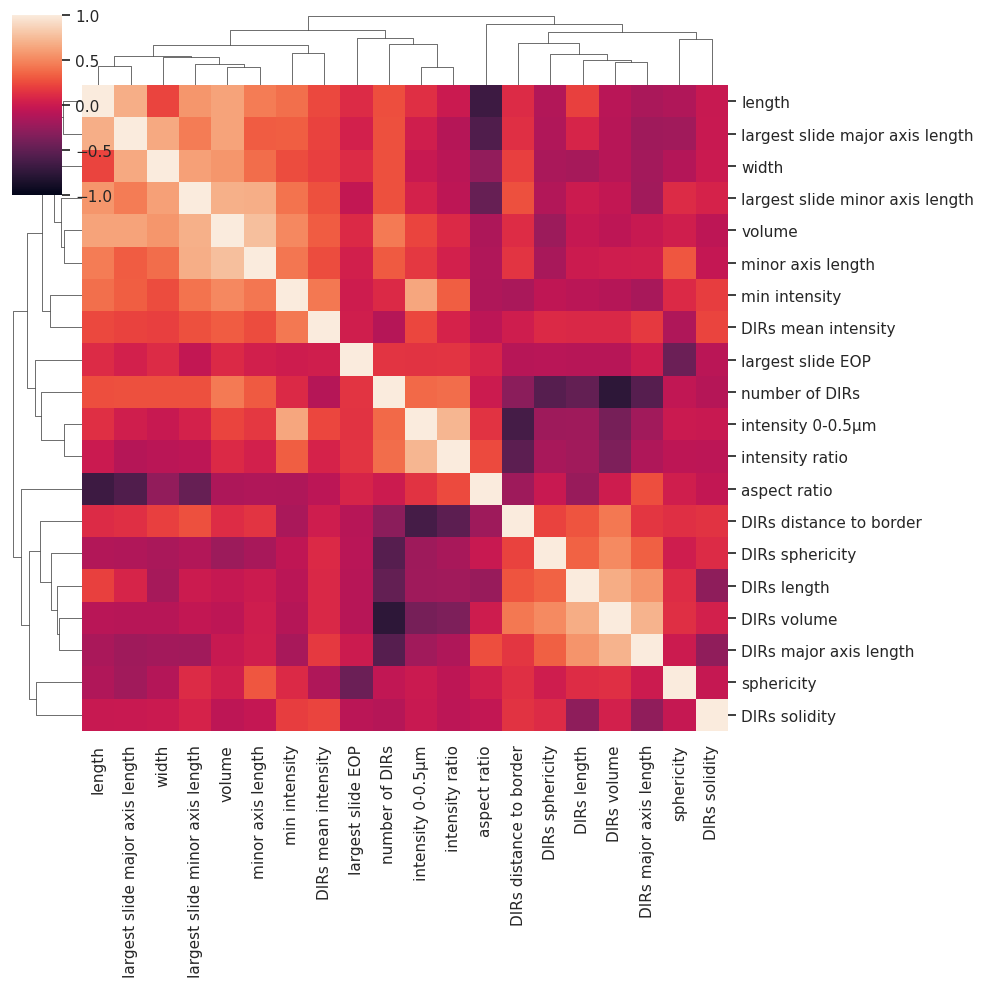

In [12]:
sns.clustermap(
    subset_df[sig_f_both].corr(), dendrogram_ratio=0.1, vmin=-1, vmax=1
)

In [15]:
corr_matrix = subset_df[sig_f_both].corr()

# Create mask to exclude diagonal elements
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Calculate average absolute correlation excluding diagonal
avg_abs_corr = corr_matrix.abs().where(mask).stack().mean()
print(f"Average absolute correlation (excluding diagonal): {avg_abs_corr:.2f}")

Average absolute correlation (excluding diagonal): 0.22


In [15]:
subset_df.reset_index(drop=True, inplace=True)
subset_df.condition.value_counts()

Young        177
Aged         164
Aged + Ri    144
Name: condition, dtype: int64

[[Text(4.0, 0, ''),
  Text(6.0, 0, ''),
  Text(8.0, 0, ''),
  Text(10.0, 0, ''),
  Text(12.0, 0, ''),
  Text(14.0, 0, '')],
 [Text(0, 4.0, ''),
  Text(0, 5.0, ''),
  Text(0, 6.0, ''),
  Text(0, 7.0, ''),
  Text(0, 8.0, ''),
  Text(0, 9.0, ''),
  Text(0, 10.0, ''),
  Text(0, 11.0, ''),
  Text(0, 12.0, ''),
  Text(0, 13.0, '')]]

<Figure size 1000x600 with 0 Axes>

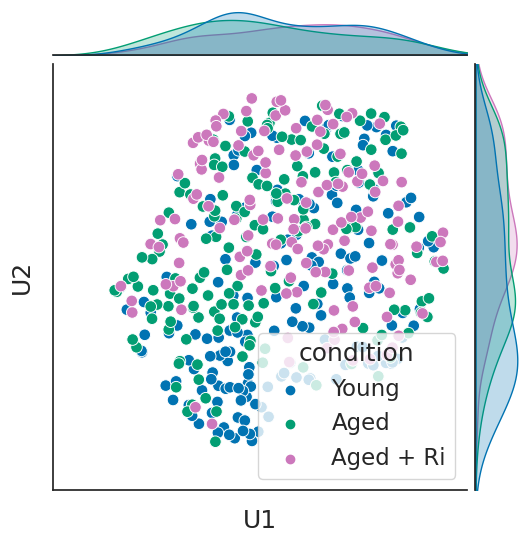

In [16]:
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)
sns.set_style("white")
# Create the UMAP object
reducer = umap.UMAP(
    min_dist=0.3,
    n_neighbors=15,
    n_components=2,
    random_state=2024,
    metric="euclidean",
)

# Extract numerical data
x = subset_df[sig_f_both].values

# Learn the scaler on the young and confined cells and apply
# it to the old and treated cells
transformer = StandardScaler()
x = transformer.fit_transform(x)

# Learn the UMAP on the young and confined cells and apply
# it to the old and treated cells
embedding = reducer.fit_transform(x)
umap_df = pd.DataFrame(data=embedding, columns=["U1", "U2"])
umap_df = pd.concat([umap_df, subset_df[features]], axis=1)

plt.figure(figsize=(10, 6))
plot = sns.jointplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="condition",
    s=70,
    palette=palette,
    height=6,
    ratio=8,
)
plot.ax_marg_x.set_xlim(4, 13)
plot.ax_marg_y.set_ylim(4, 13)
plot.ax_joint.set(xticklabels=[], yticklabels=[])

[[Text(4.0, 0, ''),
  Text(6.0, 0, ''),
  Text(8.0, 0, ''),
  Text(10.0, 0, ''),
  Text(12.0, 0, ''),
  Text(14.0, 0, '')],
 [Text(0, 4.0, ''),
  Text(0, 6.0, ''),
  Text(0, 8.0, ''),
  Text(0, 10.0, ''),
  Text(0, 12.0, ''),
  Text(0, 14.0, '')]]

<Figure size 1000x600 with 0 Axes>

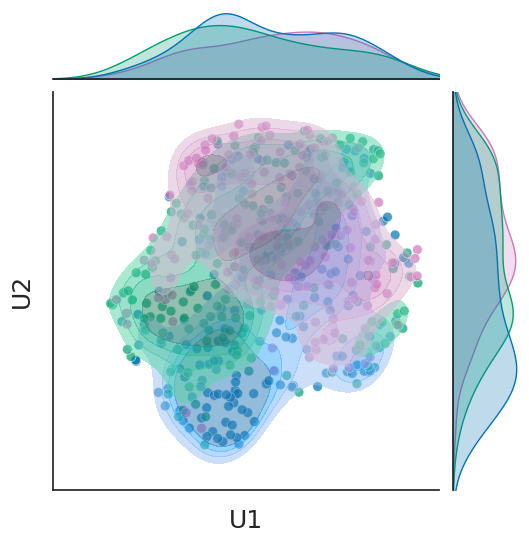

In [17]:
sns.set(font_scale=1.5)
sns.set_style("white")

plt.figure(figsize=(10, 6))

plot = sns.jointplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="condition",
    kind="scatter",
    s=50,
    palette=palette,
    alpha=0.7,
    legend=False,
)
plot.plot_joint(
    sns.kdeplot,
    data=umap_df,
    hue="condition",
    kind="kde",
    fill=True,
    levels=5,
    thresh=0.3,
    alpha=0.5,
    bw_adjust=0.75,
    palette=palette,
    legend=False,
)
plot.ax_marg_x.set_xlim(4, 13)
plot.ax_marg_y.set_ylim(4, 13)
plot.ax_joint.set(xticklabels=[], yticklabels=[])

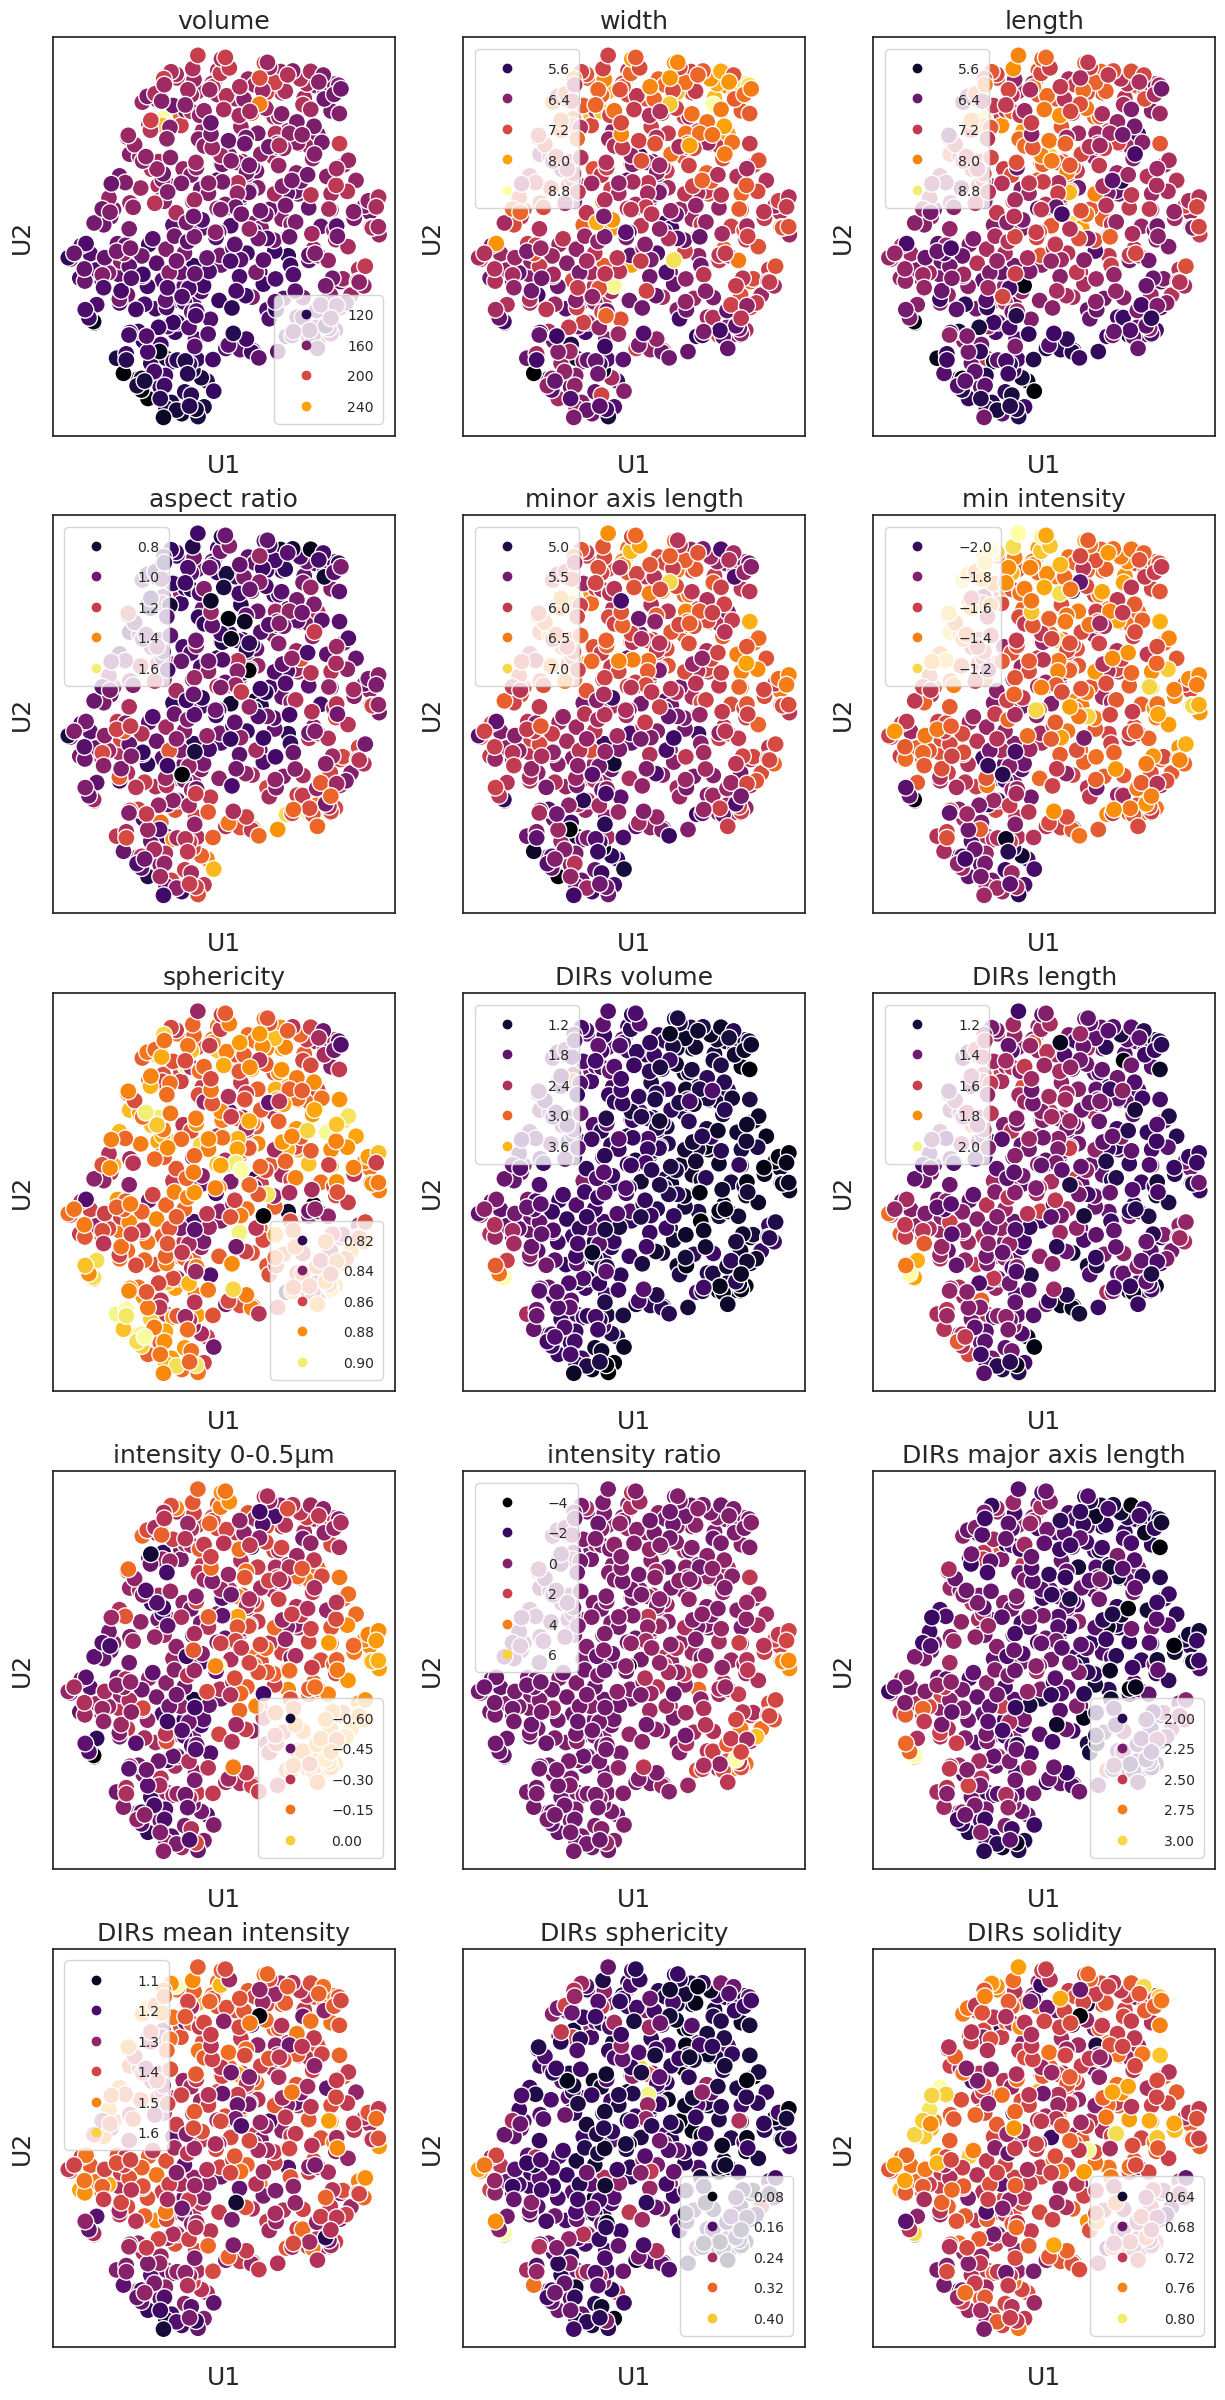

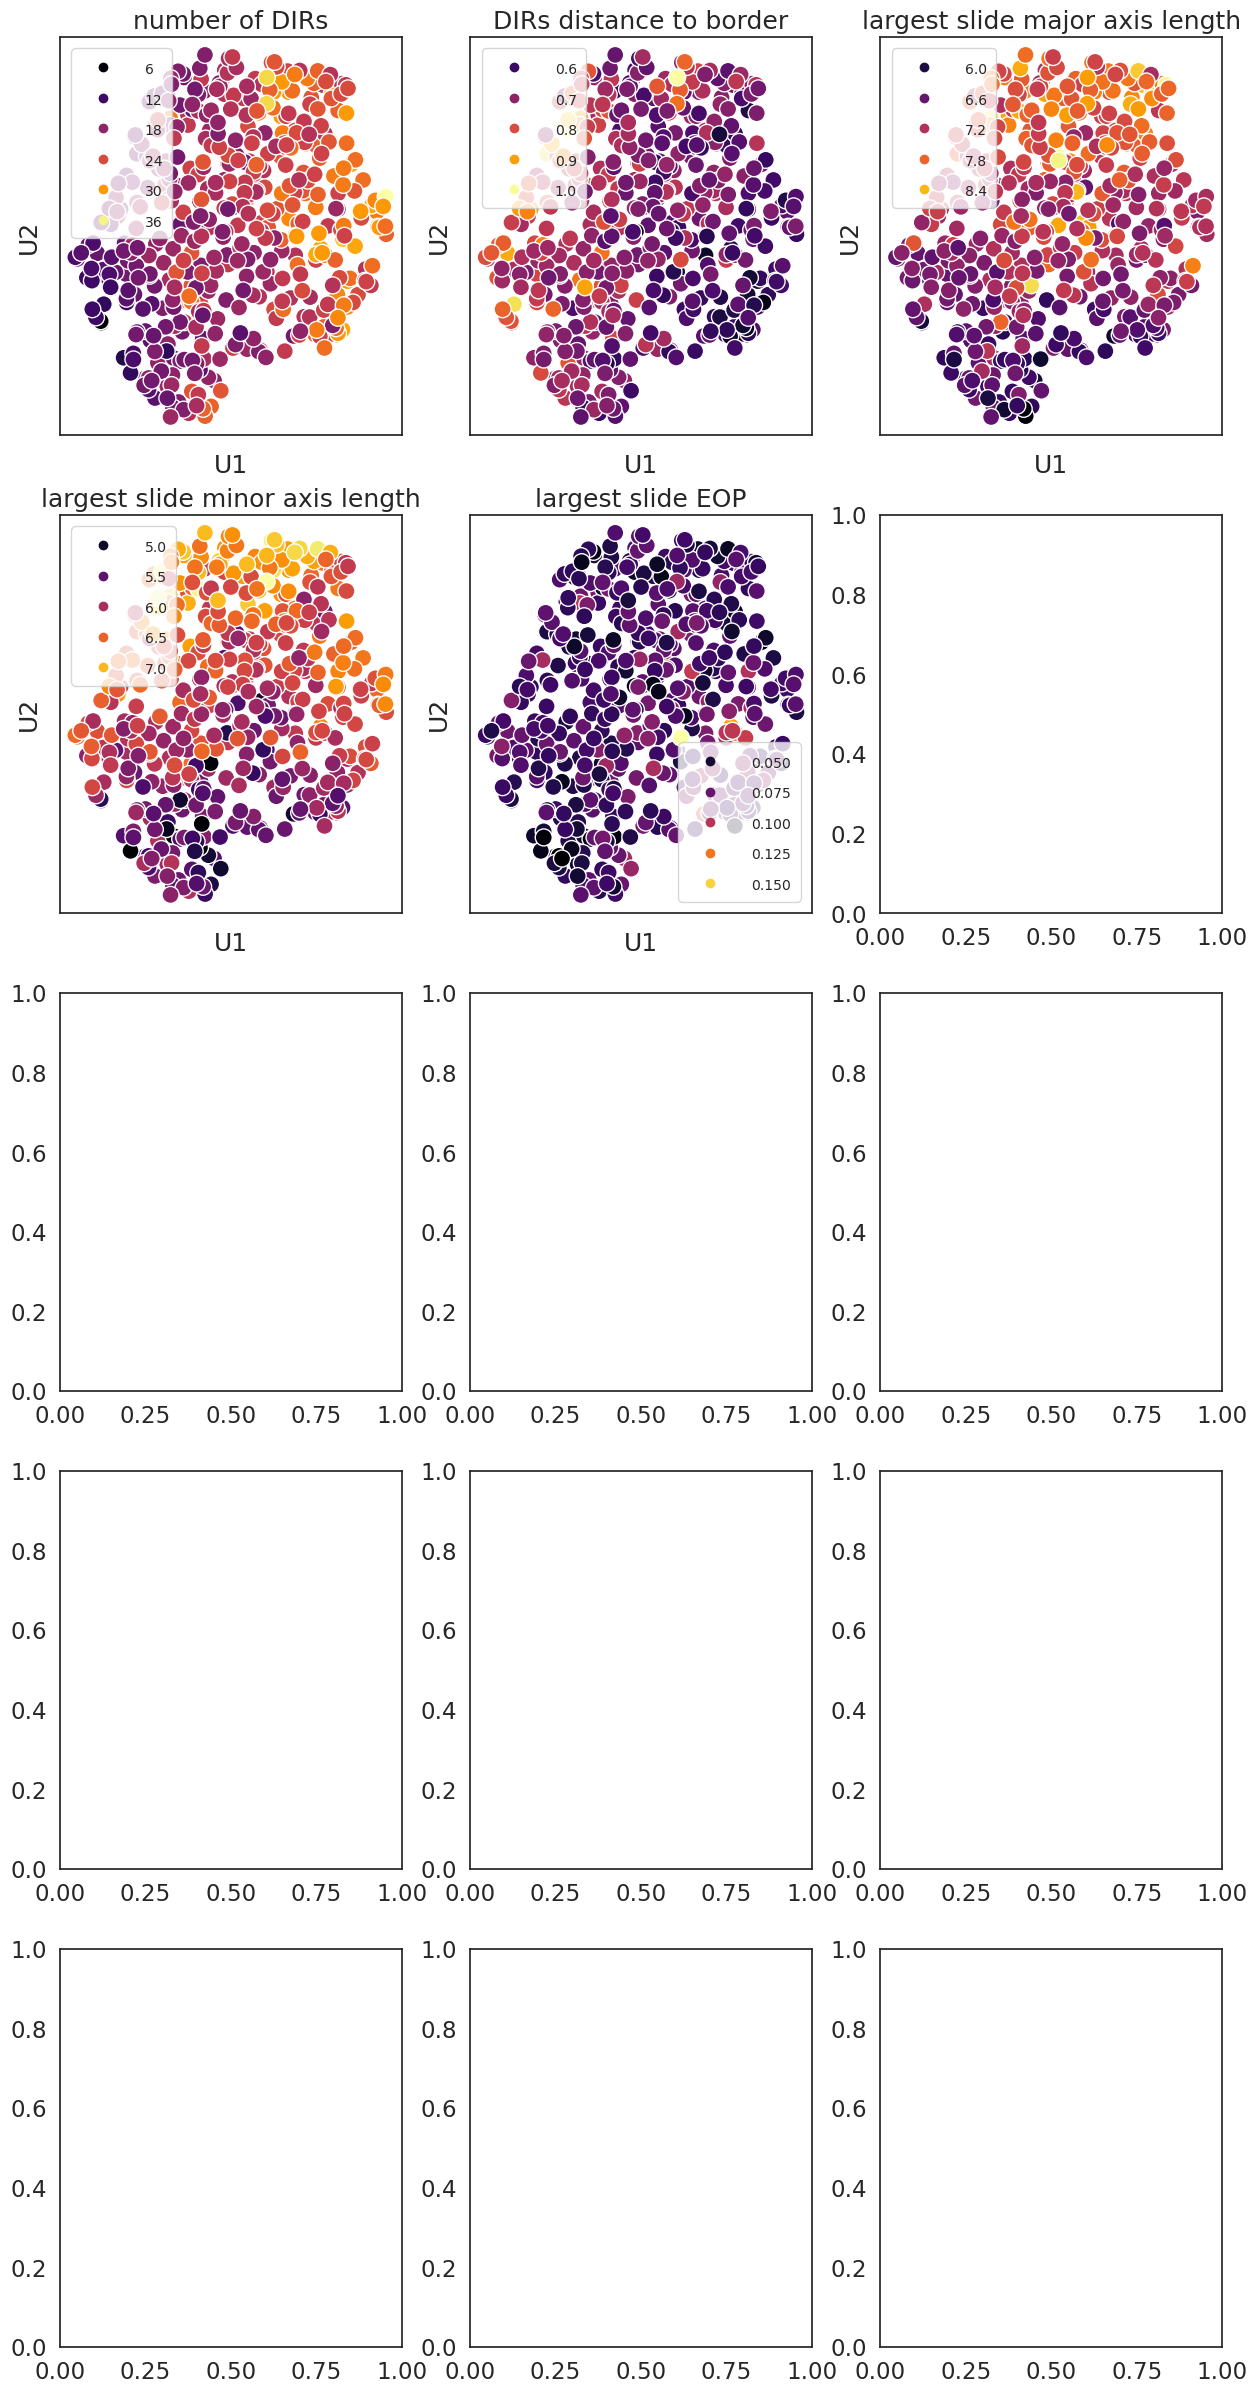

In [18]:
# Prepare to export the plots as a pdf file
pdf = PdfPages(f"../results/ZSCORENORM_umaps_{res}_cft{cft}.pdf")

sns.set_style("white")

fig, axs = plt.subplots(5, 3, figsize=(15, 30), facecolor="white")
axs = axs.flat

i = 0

# Plot the UMAPs for the effect of each feature
for m in sig_f_both:
    if (i + 1) % 16 == 0:
        pdf.savefig()
        fig, axs = plt.subplots(5, 3, figsize=(15, 30), facecolor="white")
        axs = axs.flat
        i = 0

    sns.scatterplot(
        data=umap_df,
        x="U1",
        y="U2",
        hue=m,
        s=150,
        ax=axs[i],
        legend=True,
        palette="inferno",
    )
    axs[i].title.set_text(m)
    axs[i].set(xticklabels=[], yticklabels=[])
    axs[i].legend_.set_title(None)
    plt.setp(axs[i].legend_.get_texts(), fontsize=10)
    i += 1

pdf.savefig()
pdf.close()

[[Text(4.0, 0, ''),
  Text(6.0, 0, ''),
  Text(8.0, 0, ''),
  Text(10.0, 0, ''),
  Text(12.0, 0, ''),
  Text(14.0, 0, '')],
 [Text(0, 4.0, ''),
  Text(0, 5.0, ''),
  Text(0, 6.0, ''),
  Text(0, 7.0, ''),
  Text(0, 8.0, ''),
  Text(0, 9.0, ''),
  Text(0, 10.0, ''),
  Text(0, 11.0, ''),
  Text(0, 12.0, ''),
  Text(0, 13.0, '')]]

<Figure size 1000x600 with 0 Axes>

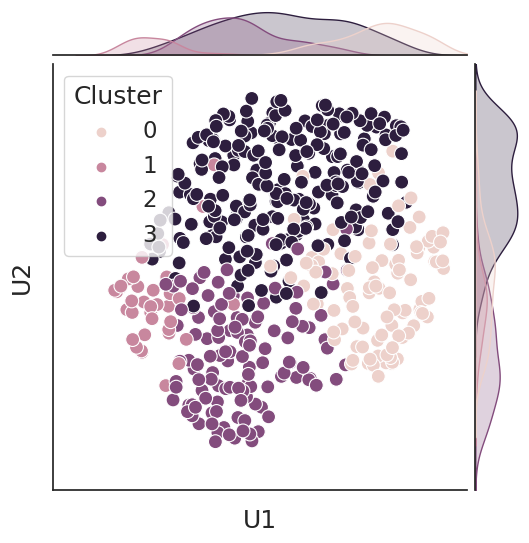

In [19]:
plt.figure(figsize=(10, 6))

# Perform clustering using the original numerical values
X = pd.DataFrame(x, columns=sig_f_both)
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
umap_df["Cluster"] = kmeans.labels_
plot = sns.jointplot(
    data=umap_df, x="U1", y="U2", hue="Cluster", s=100, height=6, ratio=8
)
plot.ax_marg_x.set_xlim(4, 13)
plot.ax_marg_y.set_ylim(4, 13)
plot.ax_joint.set(xticklabels=[], yticklabels=[])

In [20]:
umap_df["Cluster"] = umap_df["Cluster"].astype("category")
mapping = {0: "BI", 1: "CI", 2: "LS", 3: "HS"}
umap_df["Cluster"] = umap_df["Cluster"].cat.rename_categories(mapping)

In [21]:
umap_df.Cluster.value_counts()

HS    230
LS    121
BI     97
CI     37
Name: Cluster, dtype: int64

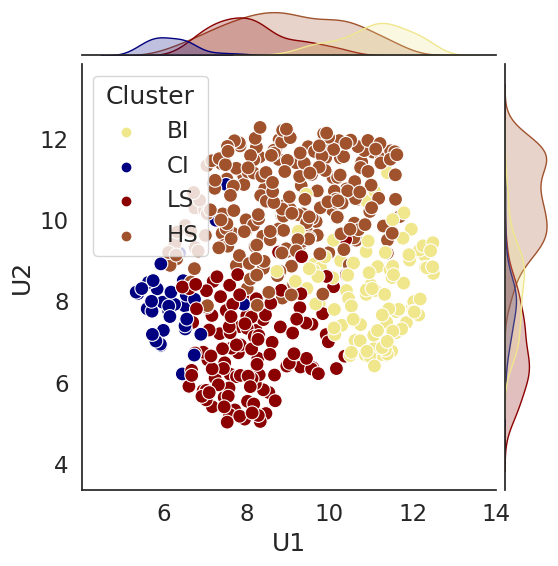

In [22]:
clus_pal = {"BI": "khaki", "CI": "navy", "LS": "darkred", "HS": "sienna"}

sns.jointplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="Cluster",
    palette=clus_pal,
    s=100,
    height=6,
    ratio=8,
)

<Axes: title={'center': 'Silhouette Plot for 4 clusters'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

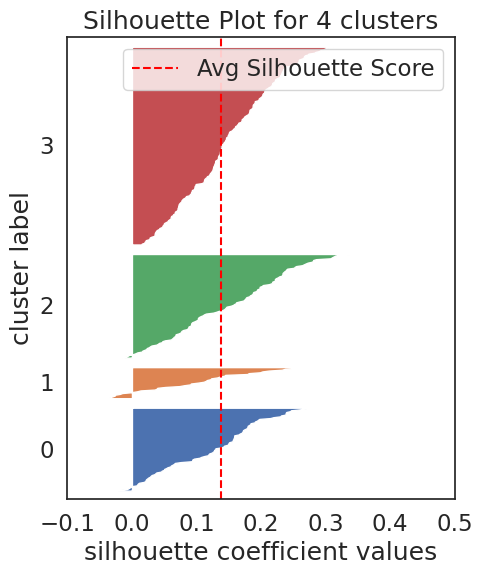

In [23]:
# Plot the silhouette chart to assess the clustering quality
fig, ax = plt.subplots(figsize=(5, 6))
hsc.silhouette_plot(x, kmeans, ax)

Text(0, 0.5, 'Number of HSC per condition')

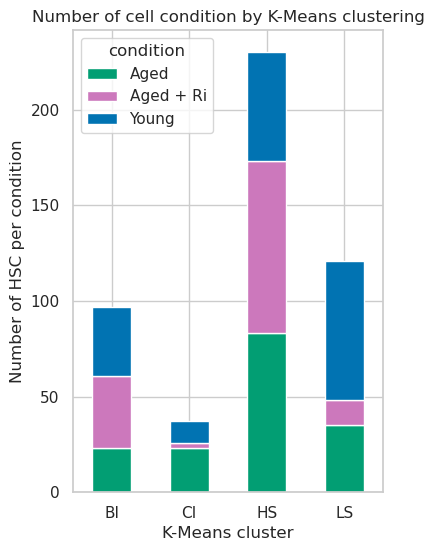

In [25]:
sns.set(rc={"figure.figsize": (4, 6)})
sns.set_style("whitegrid")

subset_df["Cluster"] = umap_df["Cluster"]
# Build dataframe of grouped variables (can I make it shorter and more elegant?)
toplot = hsc.groupby_and_count(subset_df, group1="Cluster", group2="condition")
toplot = toplot.fillna(0)

# Make color consistent with the UMAP conditions colors
toplot.plot(kind="bar", stacked=True, color=palette)
plt.title("Number of cell condition by K-Means clustering")
plt.xlabel("K-Means cluster")
plt.xticks(rotation=0)
plt.ylabel("Number of HSC per condition")

Text(0, 0.5, 'Percentage of HSC per condition (%)')

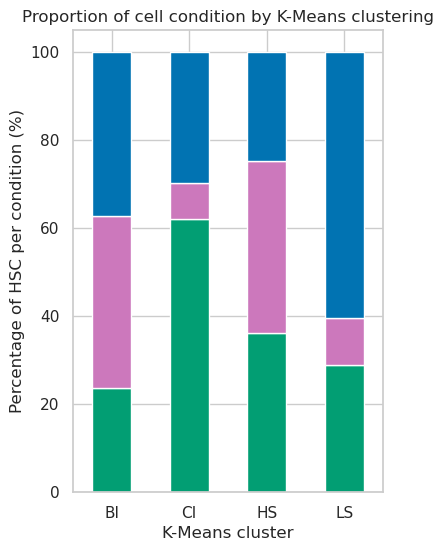

In [26]:
# Plot in percentages instead of absolute numbers
stacked = toplot.apply(lambda x: x * 100 / sum(x), axis=1)
stacked.plot(kind="bar", stacked=True, color=palette, legend=False)
plt.title("Proportion of cell condition by K-Means clustering")
plt.xlabel("K-Means cluster")
plt.xticks(rotation=0)
plt.ylabel("Percentage of HSC per condition (%)")

[[Text(4.0, 0, ''),
  Text(5.0, 0, ''),
  Text(6.0, 0, ''),
  Text(7.0, 0, ''),
  Text(8.0, 0, ''),
  Text(9.0, 0, ''),
  Text(10.0, 0, ''),
  Text(11.0, 0, ''),
  Text(12.0, 0, ''),
  Text(13.0, 0, '')],
 [Text(0, 4.0, ''),
  Text(0, 5.0, ''),
  Text(0, 6.0, ''),
  Text(0, 7.0, ''),
  Text(0, 8.0, ''),
  Text(0, 9.0, ''),
  Text(0, 10.0, ''),
  Text(0, 11.0, ''),
  Text(0, 12.0, ''),
  Text(0, 13.0, '')]]

<Figure size 1000x600 with 0 Axes>

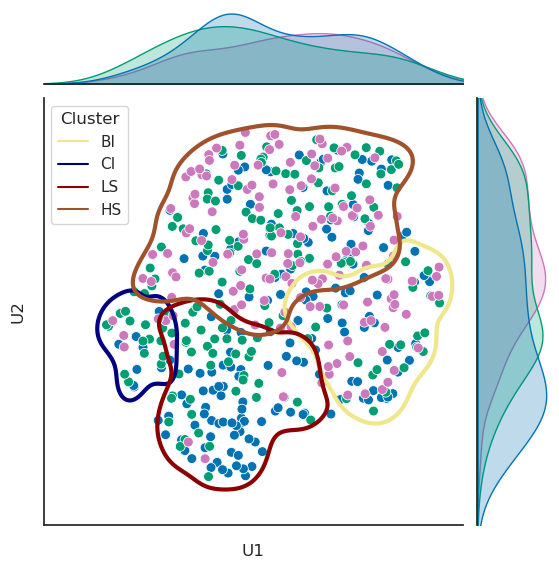

In [27]:
plt.figure(figsize=(10, 6))
sns.set_style("white")

plot = sns.jointplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="condition",
    kind="scatter",
    s=50,
    palette=palette,
)
sns.kdeplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="Cluster",
    kind="kde",
    fill=False,
    levels=2,
    thresh=0.18,
    linewidths=3,
    bw_adjust=0.75,
    palette=clus_pal,
)

plot.ax_marg_x.set_xlim(4, 13)
plot.ax_marg_y.set_ylim(4, 13)
plot.ax_joint.set(xticklabels=[], yticklabels=[])

[[Text(4.0, 0, ''),
  Text(6.0, 0, ''),
  Text(8.0, 0, ''),
  Text(10.0, 0, ''),
  Text(12.0, 0, ''),
  Text(14.0, 0, '')],
 [Text(0, 4.0, ''),
  Text(0, 6.0, ''),
  Text(0, 8.0, ''),
  Text(0, 10.0, ''),
  Text(0, 12.0, ''),
  Text(0, 14.0, '')]]

<Figure size 1000x600 with 0 Axes>

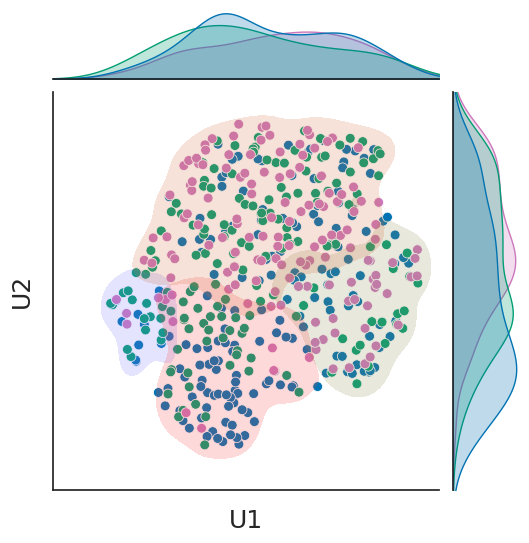

In [28]:
sns.set(font_scale=1.5)
sns.set_style("white")

plt.figure(figsize=(10, 6))

plot = sns.jointplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="condition",
    kind="scatter",
    s=50,
    palette=palette,
    legend=False,
)
sns.kdeplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="Cluster",
    kind="kde",
    fill=True,
    alpha=0.2,
    levels=2,
    thresh=0.16,
    linewidths=2,
    bw_adjust=0.75,
    palette=clus_pal,
    legend=False,
)

plot.ax_marg_x.set_xlim(4, 13)
plot.ax_marg_y.set_ylim(4, 13)
plot.ax_joint.set(xticklabels=[], yticklabels=[])

In [29]:
pv_df = hsc.get_p_values_clusters(
    subset_df,
    subset_df.columns[:-5],
    by_col="Cluster",
    group="LS",
)

In [30]:
pv_df.sort_values(by="p_float", ascending=True)

p_float p_string significance  <0.05  \
largest slide perimeter           1.732769e-44  0.00000          ***   True   
volume                            8.258356e-43  0.00000          ***   True   
largest slide area                9.538436e-43  0.00000          ***   True   
surface area                      1.597079e-42  0.00000          ***   True   
largest slide compactness         8.922387e-42  0.00000          ***   True   
largest slide minor axis length   4.156071e-35  0.00000          ***   True   
length                            3.429877e-34  0.00000          ***   True   
minor axis length                 3.568949e-33  0.00000          ***   True   
largest slide major axis length   4.352834e-31  0.00000          ***   True   
min intensity                     4.916865e-27  0.00000          ***   True   
width                             9.055484e-22  0.00000          ***   True   
intensity 0-0.5µm                 5.627694e-13  0.00000          ***   True   
major axis length                 3.161216e-12  0.00000          ***   True   
aspect ratio                      5.942247e-12  0.00000          ***   True   
number of DIRs                    9.601599e-12  0.00000          ***   True   
DIRs mean intensity               3.085794e-11  0.00000          ***   True   
intensity 1-1.5µm                 5.676114e-08  0.00000          ***   True   
DIRs max intensity                5.820721e-08  0.00000          ***   True   
intensity ratio                   2.807084e-07  0.00000          ***   True   
max intensity                     2.202596e-06  0.00000          ***   True   
DIRs surface/volume               3.877672e-06  0.00000          ***   True   
DIRs sphericity                   7.079075e-06  0.00001          ***   True   
DIRs surface area                 9.460440e-06  0.00001          ***   True   
largest slide EOP                 8.295710e-04  0.00083          ***   True   
largest slide roundness           1.052583e-02  0.01053            *   True   
DIRs height                       1.676390e-02  0.01676            *   True   
DIRs major axis length            4.032391e-02  0.04032            *   True   
DIRs aspect ratio                 1.150912e-01  0.11509           ns  False   
DIRs solidity                     1.284331e-01  0.12843           ns  False   
DIRs volume                       1.385065e-01  0.13851           ns  False   
DIRs length                       2.883640e-01  0.28836           ns  False   
height                            4.589202e-01  0.45892           ns  False   
DIRs width                        6.992376e-01  0.69924           ns  False   
sphericity                        7.711399e-01  0.77114           ns  False   
DIRs distance to border           7.958756e-01  0.79588           ns  False   
height deviation                  8.424273e-01  0.84243           ns  False   
DIRs centroid distance to border  8.859876e-01  0.88599           ns  False   
invagination proportion           8.966409e-01  0.89664           ns  False   
solidity                          8.966409e-01  0.89664           ns  False   

                                  <0.01  <0.001  
largest slide perimeter            True    True  
volume                             True    True  
largest slide area                 True    True  
surface area                       True    True  
largest slide compactness          True    True  
largest slide minor axis length    True    True  
length                             True    True  
minor axis length                  True    True  
largest slide major axis length    True    True  
min intensity                      True    True  
width                              True    True  
intensity 0-0.5µm                  True    True  
major axis length                  True    True  
aspect ratio                       True    True  
number of DIRs                     True    True  
DIRs mean intensity                True    True  
intensity 1-1.5µm           

In [31]:
X["Cluster"] = umap_df["Cluster"]

X_log2fc = hsc.calculate_logfoldchange(X)
X_log2fc

BI        CI        LS        HS
volume                           0.482085 -0.344986 -1.897608  0.953693
width                           -0.032997 -0.313525 -0.989105  0.993887
length                           0.339753 -0.360008 -1.585200  0.982864
aspect ratio                     0.292363  0.015474  0.432872 -0.942920
minor axis length                0.229251  0.139025 -1.654235  0.722096
min intensity                    0.770453 -0.342136 -1.466928  0.508719
sphericity                      -0.294565  0.059327  0.086634  0.128631
DIRs volume                     -1.572006  1.558859 -0.402321 -0.394406
DIRs length                     -0.983221  1.158351 -0.389419 -0.188998
intensity 0-0.5µm                1.530886 -1.459492 -0.787717 -0.082533
intensity ratio                  1.506493 -1.000673 -0.593789 -0.508042
DIRs major axis length          -0.842714  1.233514 -0.231921 -0.575598
DIRs mean intensity              0.053725  0.340950 -0.847839  0.291977
DIRs sphericity                 -0.916096  1.064209 -0.033809 -0.474257
DIRs solidity                   -0.096978  0.195292 -0.163051  0.051474
number of DIRs                   1.477756      -inf -0.454476  0.516727
DIRs distance to border         -1.973772  1.061901 -0.172290  0.244881
largest slide major axis length  0.144949 -0.675642 -1.287491  1.224685
largest slide minor axis length -0.021713  0.018719 -1.692911  1.041398
largest slide EOP                0.458929  0.043566 -0.408512 -0.163481

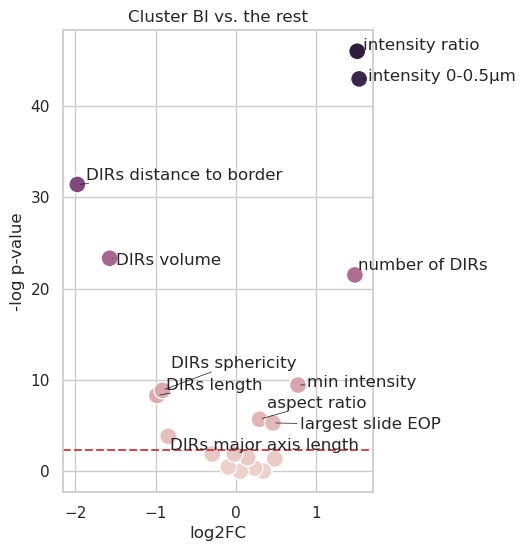

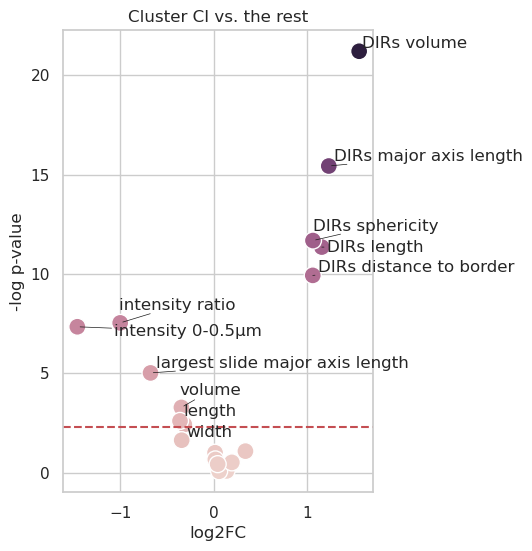

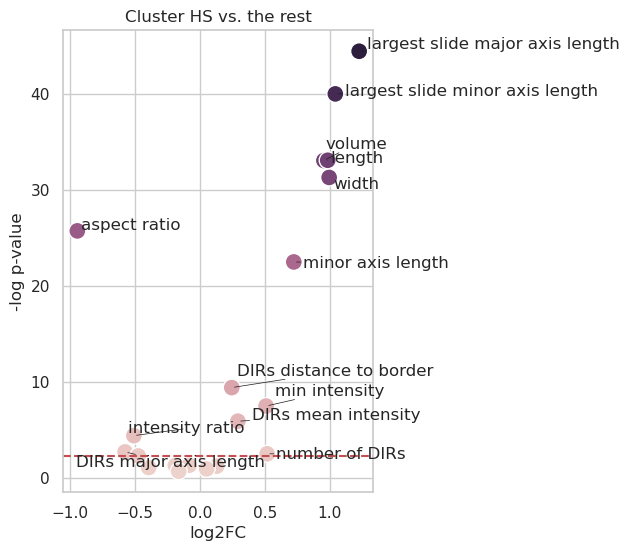

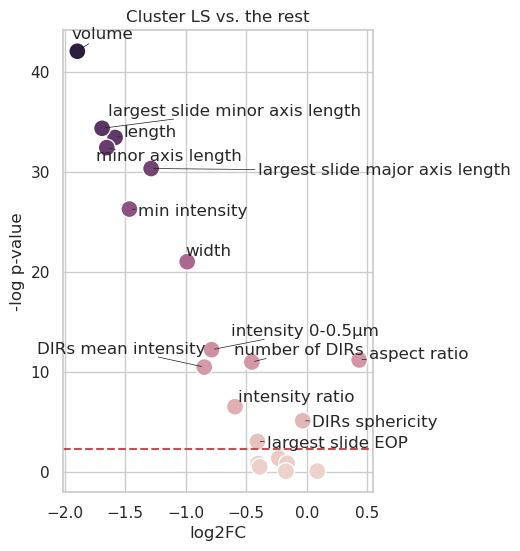

In [32]:
from adjustText import adjust_text

sns.set(font_scale=1)
sns.set_style("whitegrid")

signif = 0.005

for c in np.unique(umap_df["Cluster"]):

    pv_df = hsc.get_p_values_clusters(
        subset_df,
        subset_df.columns[:-5],
        by_col="Cluster",
        group=c,
    )

    pv_df = pv_df.loc[X_log2fc.index]
    df = pd.concat([X_log2fc[c], pv_df["p_float"]], axis=1)
    df.columns = ["log2FC", "p_value"]

    sns.scatterplot(
        x=df["log2FC"],
        y=df["p_value"].apply(lambda x: -np.log10(x)),
        hue=df["p_value"].apply(lambda x: -np.log10(x)),
        s=150,
        legend=False,
    )

    texts = []
    for i, r in df.iterrows():
        if r["p_value"] < signif:
            texts.append(
                plt.text(x=r["log2FC"], y=-np.log10(r["p_value"]), s=i)
            )
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle="-", color="k", lw=0.5),
        ensure_inside_axes=False,
    )

    plt.xlabel("log2FC")
    plt.ylabel("-log p-value")
    plt.axhline(-np.log10(signif), color="r", linestyle="--")
    plt.title(f"Cluster {c} vs. the rest")
    plt.show()

In [33]:
sig_f = pv_df[pv_df["<0.05"]].index.to_list()
sig_f

['volume',
 'width',
 'length',
 'aspect ratio',
 'minor axis length',
 'min intensity',
 'intensity 0-0.5µm',
 'intensity ratio',
 'DIRs major axis length',
 'DIRs mean intensity',
 'DIRs sphericity',
 'number of DIRs',
 'largest slide major axis length',
 'largest slide minor axis length',
 'largest slide EOP']

In [34]:
# Build dataframe of grouped variables (can I make it shorter and more elegant?)
n_bycluster = hsc.groupby_and_count(
    subset_df, group1="Cluster", group2="condition"
)
# prop_bycluster = n_bycluster
prop_bycluster = n_bycluster.apply(lambda x: x * 100 / sum(x), axis=1)
prop_bycluster["Cluster"] = prop_bycluster.index
prop_bycluster

condition       Aged  Aged + Ri      Young Cluster
Cluster                                           
BI         23.711340  39.175258  37.113402      BI
CI         62.162162   8.108108  29.729730      CI
HS         36.086957  39.130435  24.782609      HS
LS         28.925620  10.743802  60.330579      LS

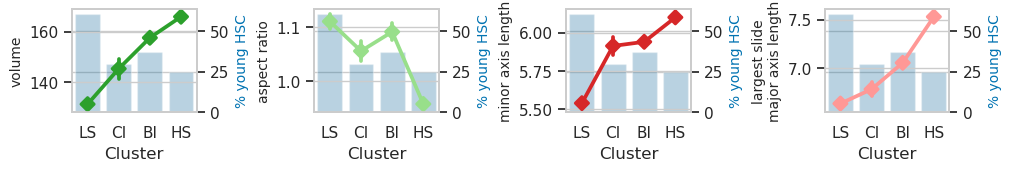

In [35]:
fig, axes = plt.subplots(1, 4, figsize=(10, 1.6), constrained_layout=True)

sig_f_morphology = [
    "volume",
    "aspect ratio",
    "minor axis length",
    "largest slide major axis length",
]

pal = sns.color_palette("tab20")[4:8]

for m, p, a1 in zip(sig_f_morphology, pal, axes.flatten()):
    plota = sns.barplot(
        ax=a1,
        data=prop_bycluster,
        x="Cluster",
        y="Young",
        dodge=False,
        errorbar="se",
        color=palette["Young"],
        order=["LS", "CI", "BI", "HS"],
        alpha=0.3,
    )

    a2 = a1.twinx()
    plotb = sns.pointplot(
        ax=a2,
        data=subset_df,
        x="Cluster",
        y=m,
        markers="D",
        dodge=False,
        errorbar="se",
        color=p,
        order=["LS", "CI", "BI", "HS"],
    )

    # Move the y-axis of ax1 to the right
    a1.yaxis.set_label_position("right")
    a1.yaxis.tick_right()
    a1.set_ylabel("% young HSC", fontsize=10, color=palette["Young"])

    # Move the y-axis of ax2 to the left
    a2.yaxis.set_label_position("left")
    a2.yaxis.tick_left()

    if m == "largest slide major axis length":
        a2.set_ylabel("largest slide\nmajor axis length", fontsize=10)
    else:
        a2.set_ylabel(a2.get_ylabel(), fontsize=10)

plt.show()

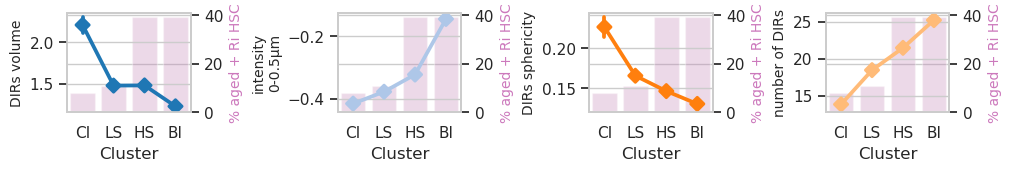

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(10, 1.6), constrained_layout=True)

sig_f_intensity = [
    "DIRs volume",
    "intensity 0-0.5µm",
    "DIRs sphericity",
    "number of DIRs",
]

pal = sns.color_palette("tab20")[:4]

for m, p, a1 in zip(sig_f_intensity, pal, axes.flatten()):
    sns.barplot(
        ax=a1,
        data=prop_bycluster,
        x="Cluster",
        y="Aged + Ri",
        dodge=False,
        errorbar="se",
        color=palette["Aged + Ri"],
        order=["CI", "LS", "HS", "BI"],
        alpha=0.3,
    )
    a2 = a1.twinx()
    b = sns.pointplot(
        ax=a2,
        data=subset_df,
        x="Cluster",
        y=m,
        markers="D",
        dodge=False,
        errorbar="se",
        color=p,
        order=["CI", "LS", "HS", "BI"],
    )

    # Move the y-axis of ax1 to the right
    a1.yaxis.set_label_position("right")
    a1.yaxis.tick_right()
    a1.set_ylabel("% aged + Ri HSC", fontsize=10, color=palette["Aged + Ri"])

    # Move the y-axis of ax2 to the left
    a2.yaxis.set_label_position("left")
    a2.yaxis.tick_left()
    if m == "intensity 0-0.5µm":
        b.set_ylabel("intensity\n0-0.5µm", fontsize=10)
    else:
        b.set_ylabel(b.get_ylabel(), fontsize=10)

plt.show()

In [37]:
sns.set(rc={"figure.figsize": (4, 6)})

# Build dataframe of grouped variables (can I make it shorter and more elegant?)
toplot = hsc.groupby_and_count(subset_df, group1="Cluster", group2="condition")
toplot = toplot.fillna(0)

In [38]:
toplot

condition  Aged  Aged + Ri  Young
Cluster                          
BI           23         38     36
CI           23          3     11
HS           83         90     57
LS           35         13     73

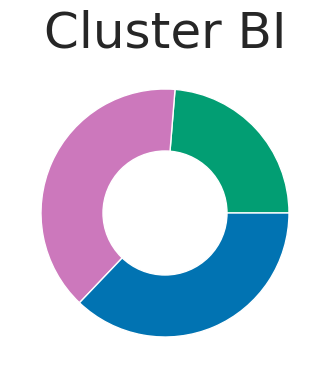

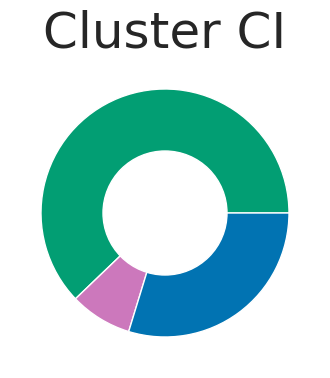

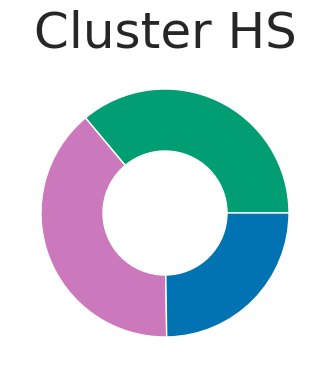

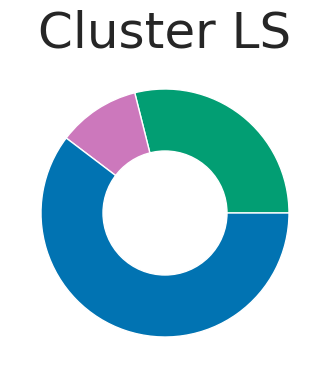

In [39]:
sns.set(font_scale=3)

for i, (_, row) in enumerate(toplot.iterrows()):
    conds = [k for k in palette if row[k] > 0.0]
    conds.sort()
    row.plot.pie(colors=[palette[k] for k in conds], labels=None)
    my_circle = plt.Circle((0, 0), 0.5, color="white")
    ax = plt.gcf().gca()
    ax.add_artist(my_circle)
    ax.set_ylabel("")
    plt.title(f"Cluster {row.name}")
    plt.show()